# Projet de Reinforcement Learning — PPO sur BipedalWalker-v3

L’objectif de ce notebook est d’étudier l’algorithme PPO (Proximal Policy Optimization)
sur l’environnement BipedalWalker-v3.

Nous analysons d’abord une version de base de PPO, puis une version améliorée obtenue
par ajustement des hyperparamètres, afin de comparer les performances et la stabilité.


In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import spaces
import pygame
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy



c:\Users\DELL\Desktop\ml\.conda\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


## Environnement : BipedalWalker-v3

BipedalWalker-v3 est un environnement de contrôle continu dans lequel un robot bipède
doit apprendre à marcher sans tomber.

- **Observations** : état continu décrivant la posture, les vitesses et les contacts
- **Actions** : 4 actions continues contrôlant les moteurs des jambes
- **Récompense** : progression vers l’avant, avec pénalités en cas de chute ou de forte
  consommation d’énergie
- **Objectif** : maximiser la récompense cumulée par épisode


In [3]:
# Identifiant de l’environnement Gymnasium utilisé
ENV_ID = "BipedalWalker-v3"

def make_env(seed=0):
    env = gym.make(ENV_ID)
    env.reset(seed=seed)
    env = Monitor(env)   
    return env

# Test
env = make_env(0)
print(env.observation_space)
print(env.action_space)
env.close()


Box([-3.1415927 -5.        -5.        -5.        -3.1415927 -5.
 -3.1415927 -5.        -0.        -3.1415927 -5.        -3.1415927
 -5.        -0.        -1.        -1.        -1.        -1.
 -1.        -1.        -1.        -1.        -1.        -1.       ], [3.1415927 5.        5.        5.        3.1415927 5.        3.1415927
 5.        5.        3.1415927 5.        3.1415927 5.        5.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.       ], (24,), float32)
Box(-1.0, 1.0, (4,), float32)


## PPO — Version de base

Dans cette section, nous entraînons une première version de l’algorithme PPO avec des
hyperparamètres standards.  
Cette version sert de **référence** pour évaluer l’impact des améliorations ultérieures.


In [4]:
# Entraînement d’un agent PPO sur l’environnement BipedalWalker-v3

TIMESTEPS = 300_000
SEED = 0

env = make_env(SEED)

model_ppo = PPO(
    "MlpPolicy",
    env,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    verbose=0,
    seed=SEED
)

start = time.time()
model_ppo.learn(total_timesteps=TIMESTEPS)
time_ppo = time.time() - start

ppo_rewards = env.get_episode_rewards()
env.close()

print("PPO training time (s):", round(time_ppo, 2))

PPO training time (s): 367.94


In [5]:
# Évaluation du modèle PPO entraîné.
env = make_env(123)
ppo_mean, ppo_std = evaluate_policy(model_ppo, env, n_eval_episodes=20, deterministic=True)
env.close()

print("PPO mean reward:", ppo_mean)
print("PPO std:", ppo_std)

PPO mean reward: 262.1993700499999
PPO std: 68.47036168339241


### Analyse des résultats — PPO de base

La courbe des récompenses montre une phase d’apprentissage initiale difficile, suivie
d’une amélioration progressive des performances.  
Cependant, la forte variabilité des récompenses indique une politique encore instable,
avec des chutes fréquentes du robot.


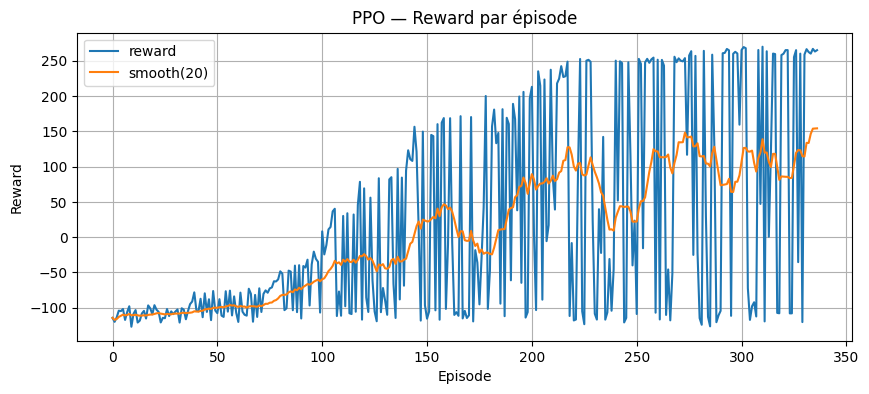

In [6]:
# Visualisation de l’apprentissage du modèle PPO.
r = np.array(ppo_rewards)
smooth = pd.Series(r).rolling(20, min_periods=1).mean()

plt.figure(figsize=(10,4))
plt.plot(r, label="reward")
plt.plot(smooth, label="smooth(20)")
plt.title("PPO — Reward par épisode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.show()

## PPO — Version améliorée

Afin d’améliorer la stabilité et les performances, nous ajustons plusieurs
hyperparamètres de PPO :

- réduction du learning rate,
- augmentation du nombre de pas par mise à jour (`n_steps`),
- augmentation de la taille des batchs,
- réduction du `clip_range`.

L’objectif est d’obtenir une politique plus stable et plus performante.


In [7]:
# Définition des hyperparamètres de la version améliorée de PPO.
TIMESTEPS_IMPROVED = 1_000_000   
SEED_IMPROVED = 0

PPO_IMPROVED_PARAMS = dict(
    learning_rate=2.5e-4,   # un peu plus petit => plus stable
    n_steps=4096,           # plus d'échantillons par update
    batch_size=128,         # gradient plus stable
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.15,        # updates moins agressifs
    ent_coef=0.0,           
    verbose=0,
    seed=SEED_IMPROVED
)

print("PPO improved params:", PPO_IMPROVED_PARAMS)

PPO improved params: {'learning_rate': 0.00025, 'n_steps': 4096, 'batch_size': 128, 'gamma': 0.99, 'gae_lambda': 0.95, 'clip_range': 0.15, 'ent_coef': 0.0, 'verbose': 0, 'seed': 0}


In [9]:
# Entraînement de la version améliorée de PPO
env = make_env(SEED_IMPROVED)

model_ppo_improved = PPO(
    "MlpPolicy",
    env,
    **PPO_IMPROVED_PARAMS
)

start = time.time()
model_ppo_improved.learn(total_timesteps=TIMESTEPS_IMPROVED)
time_ppo_improved = time.time() - start

ppo_improved_rewards = env.get_episode_rewards()
env.close()

print("PPO improved training time (s):", round(time_ppo_improved, 2))
print("Episodes:", len(ppo_improved_rewards))


PPO improved training time (s): 1047.25
Episodes: 847


In [10]:
# Évaluation de la version améliorée de PPO
env = make_env(123)
ppo_improved_mean, ppo_improved_std = evaluate_policy(
    model_ppo_improved, env,
    n_eval_episodes=50,  
    deterministic=True
)
env.close()

print("PPO improved mean reward:", ppo_improved_mean)
print("PPO improved std:", ppo_improved_std)

PPO improved mean reward: 298.65882777999997
PPO improved std: 21.053910808163128


### Analyse des résultats — PPO amélioré

La version améliorée de PPO montre une augmentation significative du score moyen,
ainsi qu’une forte réduction de la variance entre les épisodes.

Ces résultats indiquent une politique plus stable et plus robuste, au prix d’un
temps d’entraînement légèrement supérieur.


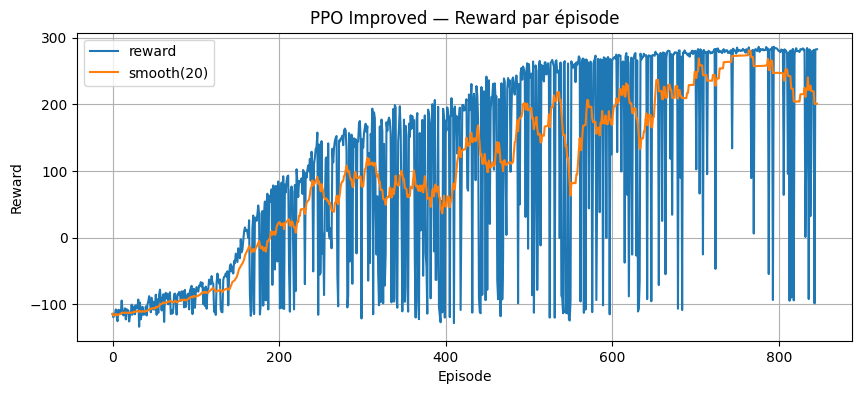

In [11]:
# Visualisation de l’apprentissage de la version améliorée de PPO.
r = np.array(ppo_improved_rewards)
smooth = pd.Series(r).rolling(20, min_periods=1).mean()

plt.figure(figsize=(10,4))
plt.plot(r, label="reward")
plt.plot(smooth, label="smooth(20)")
plt.title("PPO Improved — Reward par épisode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.show()


## Comparaison PPO — Version de base vs Version améliorée

Le tableau comparatif met en évidence les gains apportés par l’ajustement des
hyperparamètres :

- augmentation du score moyen,
- diminution importante de l’écart-type,
- surcoût computationnel limité.

Cela souligne l’importance du tuning des hyperparamètres en Reinforcement Learning.


In [12]:
compare = pd.DataFrame([
    {"Version": "PPO (ancien)", "Mean": ppo_mean, "Std": ppo_std, "Train time (s)": time_ppo},
    {"Version": "PPO improved", "Mean": float(ppo_improved_mean), "Std": float(ppo_improved_std), "Train time (s)": time_ppo_improved},
])
compare


,Version,Mean,Std,Train time (s)
0,PPO (ancien),262.199370,68.470362,367.939380
1,PPO improved,298.658828,21.053911,1047.248875


## Simulation du robot (affichage en temps réel)

Dans cette section, nous visualisons le comportement de l’agent entraîné dans
l’environnement **BipedalWalker-v3** à l’aide d’un affichage en temps réel
(`render_mode="human"`).

La simulation permet d’observer directement le mouvement du robot bipède et
d’évaluer qualitativement la politique apprise (équilibre, régularité de la marche,
fréquence des chutes).

La politique utilisée pour cette visualisation est celle du **PPO amélioré**,
car elle offre les meilleures performances et une stabilité supérieure par rapport
à la version de base.




In [13]:
# Simulation et visualisation du comportement appris par l’agent

env = gym.make("BipedalWalker-v3", render_mode="human")
obs, info = env.reset(seed=0)

for _ in range(2000):
    action, _ = model_ppo_improved.predict(obs, deterministic=True)  # ou model_ppo
    obs, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        obs, info = env.reset()

env.close()

## Jeu simplifié : Collecte de récompenses avec BipedalWalker

Afin d’introduire une dimension de **jeu simplifié** dans l’environnement BipedalWalker,
nous ajoutons une mécanique de **collecte de récompenses** sous la forme de points
(“coins”) placés le long du parcours.







In [14]:
class CoinCollectWrapper(gym.Wrapper):
    """
    Ajoute une mécanique de collecte simple :
    - des 'coins' placés à des positions X (en mètres, coordonnées monde)
    - bonus quand le robot (hull) dépasse la position
    """
    def __init__(self, env, coin_x_positions=(10, 20, 30, 40, 50), coin_bonus=5.0):
        super().__init__(env)
        self.coin_x_positions = list(coin_x_positions)
        self.coin_bonus = float(coin_bonus)
        self.collected = None

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.collected = [False] * len(self.coin_x_positions)
        info["coins_collected"] = 0
        return obs, info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        # position X du robot en coordonnées monde Box2D
        x = float(self.env.unwrapped.hull.position.x)

        coins_now = 0
        for i, cx in enumerate(self.coin_x_positions):
            if (not self.collected[i]) and (x >= cx):
                self.collected[i] = True
                reward += self.coin_bonus
        coins_now = sum(self.collected)

        info["coins_collected"] = coins_now
        info["walker_x"] = x
        return obs, reward, terminated, truncated, info


In [15]:
def play_bipedal_with_pygame_overlay(model, hardcore=False, coins=(10,20,30,40,50), coin_bonus=5.0, steps=3000, fps=60):
    env_id = "BipedalWalkerHardcore-v3" if hardcore else "BipedalWalker-v3"

    base_env = gym.make(env_id, render_mode="rgb_array")
    env = CoinCollectWrapper(base_env, coin_x_positions=coins, coin_bonus=coin_bonus)

    obs, info = env.reset(seed=0)

    pygame.init()
    frame = env.render()
    H, W = frame.shape[0], frame.shape[1]
    screen = pygame.display.set_mode((W, H))
    pygame.display.set_caption(f"{env_id} + Coins (Pygame)")
    clock = pygame.time.Clock()
    font = pygame.font.SysFont(None, 26)

    # Estimation: 30 px ≈ 1 m (typique Box2D)
    SCALE = 30.0
    viewport_w_m = W / SCALE

    ep_return = 0.0

    def world_x_to_screen_x(world_x, hull_x):
        # on estime le "scroll" (caméra) : on veut que le robot soit vers le tiers gauche de l'écran
        scroll = hull_x - viewport_w_m * 0.35
        return int((world_x - scroll) * SCALE)

    try:
        for t in range(steps):
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    return

            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            ep_return += reward

            frame = env.render()
            surf = pygame.surfarray.make_surface(frame.swapaxes(0, 1))
            screen.blit(surf, (0, 0))

            # --- HUD ---
            coins_col = info.get("coins_collected", 0)
            hull_x = float(env.unwrapped.hull.position.x)
            txt = font.render(
                f"t={t} | ep_return={ep_return:.1f} | coins={coins_col}/{len(coins)} | x={hull_x:.1f}",
                True, (0, 0, 0)
            )
            screen.blit(txt, (10, 10))

            # --- DRAW COINS (overlay) ---
            # On les dessine comme petits carrés au niveau du sol (y fixe approximatif).
            ground_y = int(H * 0.78)
            size = 10

            for i, cx in enumerate(coins):
                sx = world_x_to_screen_x(cx, hull_x)

                # afficher seulement s'il est dans l'écran
                if 0 <= sx <= W:
                    collected = env.collected[i]
                    color = (150, 150, 150) if collected else (240, 200, 40)  # gris si pris, jaune sinon
                    pygame.draw.rect(screen, color, pygame.Rect(sx - size//2, ground_y - size, size, size))
                    # petit contour
                    pygame.draw.rect(screen, (0, 0, 0), pygame.Rect(sx - size//2, ground_y - size, size, size), 1)

            pygame.display.flip()
            clock.tick(fps)

            if terminated or truncated:
                obs, info = env.reset()
                ep_return = 0.0

    finally:
        env.close()
        pygame.quit()



In [16]:
play_bipedal_with_pygame_overlay(
    model=model_ppo_improved,
    hardcore=False,
    coins=(10, 20, 30, 40, 50),
    coin_bonus=5.0,
    steps=3000,
    fps=60
)
